In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
from PIL import Image
from torchvision import transforms
from torch.nn.functional import relu
from skimage.metrics import structural_similarity as ssim

from skimage.metrics import mean_squared_error as mse

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #using gpu
print(device)

cuda:0


In [3]:
preprocess = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

Minimum value: 0.0117647061124444
Maximum value: 1.0


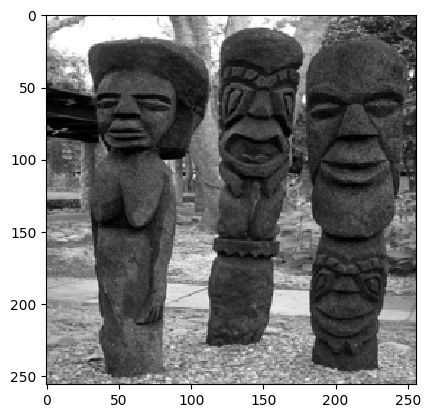

In [4]:
image = Image.open("blurImages/test001.png")
testOutput = preprocess(image).unsqueeze(0)

min_value = np.min(testOutput.squeeze(0).cpu().numpy())
max_value = np.max(testOutput.squeeze(0).cpu().numpy())
print(f"Minimum value: {min_value}")
print(f"Maximum value: {max_value}")
plt.imshow(testOutput.squeeze().numpy(),cmap='gray',interpolation='none')

In [5]:
class UNetDenoise(nn.Module):
    #layers definition
    def __init__(self): #constructor for uNetDenoise
        super().__init__() #constructor of parent class to init inherited attributes
        #Encoder portion, with 256x256x3 input. Padding: same for 3x3 convolutions

        #1st downsample layer
        self.conv11 = nn.Conv2d(1,64,kernel_size=3, padding=1) #dataset images are black and white
        self.conv12 = nn.Conv2d(64,64, kernel_size=3, padding=1) #keep padding same, (kernselSize-1)/2
        self.pool1=nn.MaxPool2d(kernel_size=2, stride=2)

        #2nd downsample layer
        self.conv21 = nn.Conv2d(64,128,kernel_size=3, padding=1)
        self.conv22 = nn.Conv2d(128,128,kernel_size=3, padding=1)
        self.pool2=nn.MaxPool2d(kernel_size=2, stride=2)

        #3rd downsample layer
        self.conv31 = nn.Conv2d(128,256,kernel_size=3, padding=1)
        self.conv32 = nn.Conv2d(256,256,kernel_size=3, padding=1)
        self.pool3=nn.MaxPool2d(kernel_size=2, stride=2)

        #4th downsample layer
        self.conv41 = nn.Conv2d(256,512,kernel_size=3, padding=1)
        self.conv42 = nn.Conv2d(512,512,kernel_size=3, padding=1)
        self.pool4=nn.MaxPool2d(kernel_size=2, stride=2)

        #bottle neck
        self.conv51 = nn.Conv2d(512,1024,kernel_size=3, padding=1)
        self.conv52 = nn.Conv2d(1024,1024,kernel_size=3, padding=1)

        #upsample 1
        self.upconv1 = nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2) #1024, but half 
        self.u11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.u12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        #upsample 2
        self.upconv2 = nn.ConvTranspose2d(512,256,kernel_size=2,stride=2)
        self.u21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.u22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        #upsample 3
        self.upconv3 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
        self.u31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.u32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        #upsample 4
        self.upconv4 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        self.u41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.u42 = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        #encoder forward
        xconv11 = relu(self.conv11(x))
        xconv12 = relu(self.conv12(xconv11))
        xpool1 = self.pool1(xconv12)

        xconv21 = relu(self.conv21(xpool1))
        xconv22 = relu(self.conv22(xconv21))
        xpool2 = self.pool2(xconv22)

        xconv31 = relu(self.conv31(xpool2))
        xconv32 = relu(self.conv32(xconv31))
        xpool3 = self.pool3(xconv32)

        xconv41 = relu(self.conv41(xpool3))
        xconv42 = relu(self.conv42(xconv41))
        xpool4 = self.pool4(xconv42)

        xconv51 = relu(self.conv51(xpool4))
        xconv52 = relu(self.conv52(xconv51))

        #decoder forward 
        xup1 = self.upconv1(xconv52)
        xu11 = torch.cat([xup1, xconv42], dim=1)
        xd11 = relu(self.u11(xu11))
        xd12 = relu(self.u12(xd11))

        xup2 = self.upconv2(xd12)
        xu22 = torch.cat([xup2, xconv32], dim=1)
        xd21 = relu(self.u21(xu22))
        xd22 = relu(self.u22(xd21))

        xup3 = self.upconv3(xd22)
        xu33 = torch.cat([xup3, xconv22], dim=1)
        xd31 = relu(self.u31(xu33))
        xd32 = relu(self.u32(xd31))

        xup4 = self.upconv4(xd32)
        xu44 = torch.cat([xup4, xconv12], dim=1)
        xd41 = relu(self.u41(xu44))
        xd42 = relu(self.u42(xd41))

        return xd42

In [6]:
kernel_size = 9

In [7]:
class BlurModel(nn.Module):
    def __init__(self):
        super(BlurModel, self).__init__()

        #self.k = torch.tensor([[1/16,1/8,1/16],[1/8,1/4,1/8],[1/16,1/8,1/16]],dtype=torch.float32) # set blur kernel
        #bigger blur kernel so it's more blurry. Gaussian distribution 10x10 blur
        #self.k = self.k.view(1,1,3,3)

        #with gaussian distribution:
        # normalDistribute = torch.normal(0, 1, size=(kernel_size,kernel_size)) #mean, std, kernel size
        # self.k = normalDistribute/normalDistribute.sum() #normalization

        self.k = torch.tensor([[5.7979e-05, 2.7469e-04, 8.3443e-04, 1.6253e-03, 2.0297e-03, 1.6253e-03,
         8.3443e-04, 2.7469e-04, 5.7979e-05],
        [2.7469e-04, 1.3014e-03, 3.9533e-03, 7.7000e-03, 9.6161e-03, 7.7000e-03,
         3.9533e-03, 1.3014e-03, 2.7469e-04],
        [8.3443e-04, 3.9533e-03, 1.2009e-02, 2.3391e-02, 2.9211e-02, 2.3391e-02,
         1.2009e-02, 3.9533e-03, 8.3443e-04],
        [1.6253e-03, 7.7000e-03, 2.3391e-02, 4.5559e-02, 5.6896e-02, 4.5559e-02,
         2.3391e-02, 7.7000e-03, 1.6253e-03],
        [2.0297e-03, 9.6161e-03, 2.9211e-02, 5.6896e-02, 7.1054e-02, 5.6896e-02,
         2.9211e-02, 9.6161e-03, 2.0297e-03],
        [1.6253e-03, 7.7000e-03, 2.3391e-02, 4.5559e-02, 5.6896e-02, 4.5559e-02,
         2.3391e-02, 7.7000e-03, 1.6253e-03],
        [8.3443e-04, 3.9533e-03, 1.2009e-02, 2.3391e-02, 2.9211e-02, 2.3391e-02,
         1.2009e-02, 3.9533e-03, 8.3443e-04],
        [2.7469e-04, 1.3014e-03, 3.9533e-03, 7.7000e-03, 9.6161e-03, 7.7000e-03,
         3.9533e-03, 1.3014e-03, 2.7469e-04],
        [5.7979e-05, 2.7469e-04, 8.3443e-04, 1.6253e-03, 2.0297e-03, 1.6253e-03,
         8.3443e-04, 2.7469e-04, 5.7979e-05]])

        self.k = self.k.view(1,1,kernel_size,kernel_size)
        self.k = self.k.to(device)
    def forward(self, x, sigma=0):
        # A y

        #need new padding size with larger kernel
        padding_size = kernel_size//2
        
        x_padded = F.pad(x, (padding_size,padding_size,padding_size,padding_size), mode='circular')
        y = F.conv2d(x_padded, self.k) + sigma * torch.randn_like(x)
        return y
    
    def tran(self, y):
        # A^T y
#         x = NotImplemented # hint: transpose the blur kernel
        self.k = torch.transpose(self.k, 0, 1)

        #need new padding size with larger kernel
        padding_size = kernel_size//2
        
        y_padded = F.pad(y, (padding_size, padding_size, padding_size, padding_size), mode='circular')
        #kTranposed = self.k.t()
        x = F.conv2d(y_padded, self.k, padding=0) #self.k is symmetric
        return x
    
    def grad(self, x, y):
        # gradient of 0.5 || Ax - y ||^2 --> grad = A^T(Ax - y)
        g = self.tran( self.forward(x) - y )
        return g
    # def calcLoss(self, x,y):
    #     diff = self.forward(x)-y #element-wise subtraction
    #     diffSquared = diff**2 #squaring by element-wise
    #     loss = 0.5*torch.sum(diffSquared) 
    #     return loss

    def calcLoss(self, x, y):
        diff = self.forward(x) - y
        diffSquared = diff ** 2
        return 0.5*torch.sum(diffSquared)


In [8]:
def psnrCalc(mse, max):
    return 10*np.log10((max**2)/mse)


In [9]:
def run_PnP_ISTA(
             x0,
             A, 
             denoiser,
             meas, 
             stepsize,
             gt_img, 
             max_iter,
            ):
    # ############################
    # A basic implementation of PnP ISTA
    # ############################
    x = x0
    for i in tqdm(range(max_iter)):
        # Look at PnP ISTA update steps
        z = x - stepsize*A.grad(x, meas) #prev x - stepsize*grad(prev x)
        x = denoiser(z)
        #x=z
    
        #Feel free to add psnr/ssim tracking
        #track loss of (y-AX)^2
        #check if fista is running properly: set x=z, initailize image to zeros, simga=0 and you'll converge
        if i % 10 == 0:
            gt_img_np = gt_img.cpu().detach().numpy() if gt_img.is_cuda else gt_img.numpy()
            x_np = x.cpu().detach().numpy() if x.is_cuda else x.detach().numpy()
            mseTerm = mse(gt_img_np,x_np)
            curPsnr = psnrCalc(mseTerm, 1)
            curLoss = A.calcLoss(x, meas)
            psnrList.append(curPsnr)
            lossList.append(curLoss) #x is clean image, y is measurement
            print(f"At iter {i}, loss is: {curLoss}, PSNR is: {curPsnr}");
    return x

step size of: 2


 10%|█         | 3/30 [00:00<00:00, 29.72it/s]

At iter 0, loss is: 5901.68701171875, PSNR is: 7.342705441157754


 37%|███▋      | 11/30 [00:00<00:00, 35.25it/s]

At iter 10, loss is: 3379.79931640625, PSNR is: 9.731653124462472


100%|██████████| 30/30 [00:00<00:00, 47.20it/s]


At iter 20, loss is: 2568.297119140625, PSNR is: 10.89307845180808
final psnr with stepsize 2: 10.89307845180808
step size of: 1


 27%|██▋       | 8/30 [00:00<00:00, 48.22it/s]

At iter 0, loss is: 30.570392608642578, PSNR is: 22.85118830025521
At iter 10, loss is: 8.145225524902344, PSNR is: 24.707141328368717


 70%|███████   | 21/30 [00:03<00:02,  4.43it/s]

At iter 20, loss is: 8.089629173278809, PSNR is: 24.72398423585133


100%|██████████| 30/30 [00:05<00:00,  5.22it/s]


final psnr with stepsize 1: 24.72398423585133
step size of: 0.9


 23%|██▎       | 7/30 [00:00<00:00, 42.97it/s]

At iter 0, loss is: 97.57133483886719, PSNR is: 21.308309110524668


 50%|█████     | 15/30 [00:00<00:00, 59.73it/s]

At iter 10, loss is: 9.021793365478516, PSNR is: 24.5980323732379


100%|██████████| 30/30 [00:00<00:00, 41.86it/s]

At iter 20, loss is: 8.945184707641602, PSNR is: 24.61650558524046
final psnr with stepsize 0.9: 24.61650558524046


step size of: 0.8


  0%|          | 0/30 [00:00<?, ?it/s]

At iter 0, loss is: 285.76751708984375, PSNR is: 18.74878665327524


 37%|███▋      | 11/30 [00:01<00:02,  7.27it/s]

At iter 10, loss is: 10.122394561767578, PSNR is: 24.472631266463353


 70%|███████   | 21/30 [00:03<00:01,  6.44it/s]

At iter 20, loss is: 10.010429382324219, PSNR is: 24.493327759659277


100%|██████████| 30/30 [00:04<00:00,  6.41it/s]


final psnr with stepsize 0.8: 24.493327759659277
step size of: 0.5


 20%|██        | 6/30 [00:00<00:00, 33.64it/s]

At iter 0, loss is: 1580.63525390625, PSNR is: 12.705431219733384


 37%|███▋      | 11/30 [00:00<00:00, 37.43it/s]

At iter 10, loss is: 16.286401748657227, PSNR is: 23.915438398838557


100%|██████████| 30/30 [00:00<00:00, 46.80it/s]


At iter 20, loss is: 15.747769355773926, PSNR is: 23.9664623671255
final psnr with stepsize 0.5: 23.9664623671255
step size of: 0.3


 13%|█▎        | 4/30 [00:00<00:01, 24.40it/s]

At iter 0, loss is: 3057.59521484375, PSNR is: 10.027865854390111


 37%|███▋      | 11/30 [00:01<00:03,  5.88it/s]

At iter 10, loss is: 28.088531494140625, PSNR is: 23.158828669938075


 70%|███████   | 21/30 [00:03<00:01,  6.21it/s]

At iter 20, loss is: 26.120563507080078, PSNR is: 23.30593292505015


100%|██████████| 30/30 [00:04<00:00,  6.69it/s]


final psnr with stepsize 0.3: 23.30593292505015
step size of: 0.1


  0%|          | 0/30 [00:00<?, ?it/s]

At iter 0, loss is: 4957.18212890625, PSNR is: 8.010502242402072


 37%|███▋      | 11/30 [00:00<00:00, 32.47it/s]

At iter 10, loss is: 615.67431640625, PSNR is: 16.18467166450716


100%|██████████| 30/30 [00:00<00:00, 41.48it/s]


At iter 20, loss is: 111.16587829589844, PSNR is: 20.8230917817291
final psnr with stepsize 0.1: 20.8230917817291
step size of: 0.05


 13%|█▎        | 4/30 [00:00<00:01, 21.99it/s]

At iter 0, loss is: 5358.3427734375, PSNR is: 7.681779169622366


 37%|███▋      | 11/30 [00:01<00:02,  6.79it/s]

At iter 10, loss is: 1968.87939453125, PSNR is: 11.797049830156077


100%|██████████| 30/30 [00:03<00:00,  9.19it/s]

At iter 20, loss is: 682.025634765625, PSNR is: 15.773958019165564
final psnr with stepsize 0.05: 15.773958019165564


step size of: 0.01


 10%|█         | 3/30 [00:00<00:01, 19.37it/s]

At iter 0, loss is: 5536.4072265625, PSNR is: 7.543782457963173


 57%|█████▋    | 17/30 [00:00<00:00, 41.35it/s]

At iter 10, loss is: 4556.8955078125, PSNR is: 8.356604912279264


100%|██████████| 30/30 [00:00<00:00, 32.84it/s]

At iter 20, loss is: 3993.662109375, PSNR is: 8.906280222002243
final psnr with stepsize 0.01: 8.906280222002243


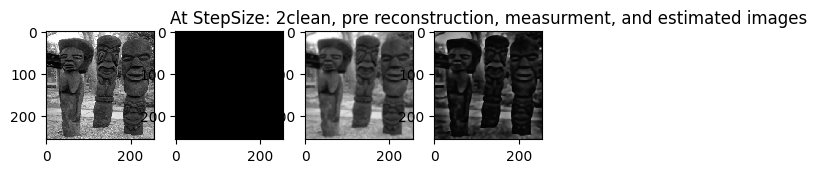

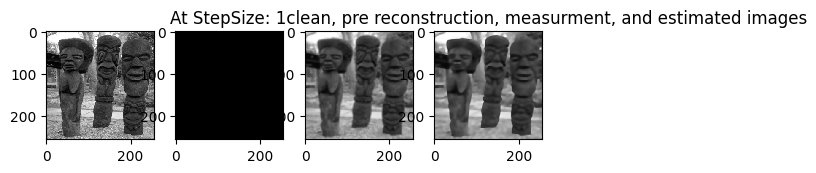

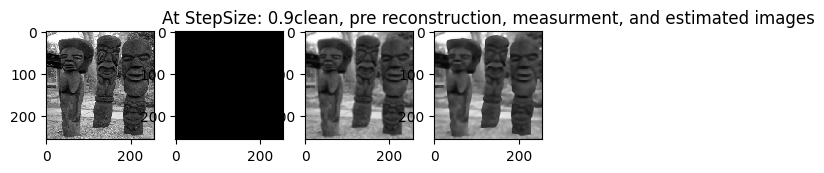

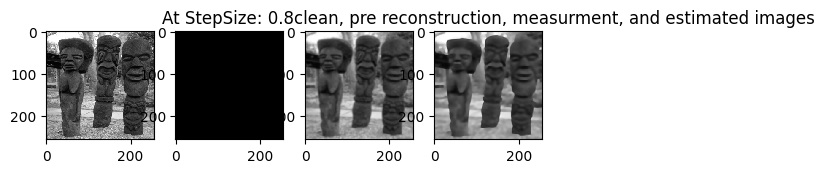

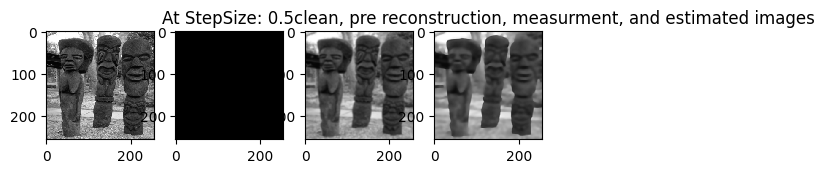

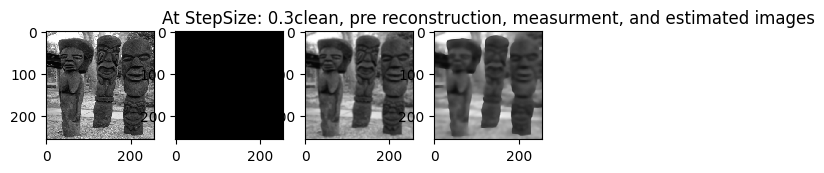

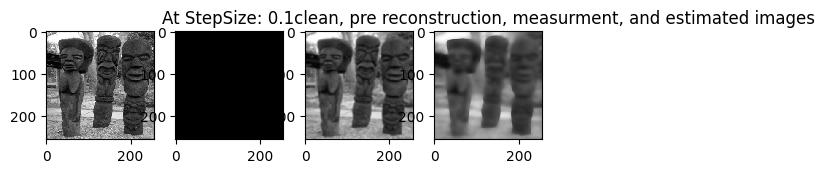

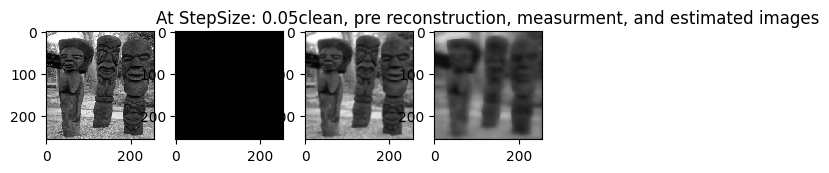

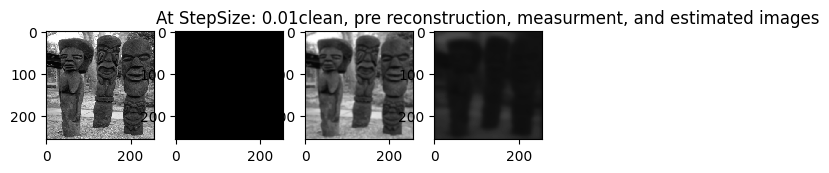

In [10]:
max_iter = 30
stepsize = [2, 1, 0.9, 0.8, 0.5, 0.3, 0.1, 0.05, 0.01] # play with this
meas_sigma = 0 / 255 # play with this (note that it does not need to be same as the sigma you used for training)

A = BlurModel().to(device) # forward model

clean_img = preprocess(image).unsqueeze(0)
clean_img = clean_img.to(device)
blurry_img = A(clean_img, sigma=meas_sigma)


network = UNetDenoise()
network.load_state_dict(torch.load('denoiserFinalWeights.pth')) # Your NN you trained 
#denoiserFinalWeights.pth denoiserModelBestWeights.pth denoiserFinalWeightsEarlyStopped.pth denoiserModelBestWeightsEarlyStopped.pth 
network.eval()

x0 = torch.zeros_like(blurry_img)
# x0 = A(clean_img, sigma=0)
network.to(device)
blurry_img = blurry_img.to(device)

x0 = x0.to(device)

for aStepsize in stepsize:
    lossList = list()
    psnrList = list()
    print(f'step size of: {aStepsize}')
    recon = run_PnP_ISTA(x0 = x0, # For deblurring, initializing with the blurry image can work
                         A = A, 
                         denoiser = network,
                         meas = blurry_img, 
                         stepsize = aStepsize,
                         gt_img = clean_img, 
                         max_iter = max_iter
                    )
    print(f'final psnr with stepsize {aStepsize}: {psnrList[-1]}')
    fig, ax = plt.subplots(1,4)
    plt.title(f'At StepSize: {aStepsize}clean, pre reconstruction, measurment, and estimated images')
    ax[0].imshow(clean_img[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
    ax[1].imshow(x0[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
    ax[2].imshow(blurry_img[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
    ax[3].imshow(recon[0,0].cpu().detach().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
